# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [26]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-6ya6kf3a/granite-tsfm_44b55ba3bdea4c0087db250f7953cd08
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-6ya6kf3a/granite-tsfm_44b55ba3bdea4c0087db250f7953cd08
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [37]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [38]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
CUDA version: 12.6
GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU


In [39]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [40]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

In [41]:
import torch
print(torch.backends.cudnn.enabled)
print(torch.backends.cudnn.version())


True
90501


# Data processing

In [42]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

## Zero-shot evaluation method

In [43]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
      indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-8808:t-139689755144320:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-8808:t-139689755144320:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-8808:t-139689755144320:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3628121316432953, 'eval_runtime': 1.2036, 'eval_samples_per_second': 2313.937, 'eval_steps_per_second': 36.558}
(2785, 96, 7)
(2785, 7, 8, 192)


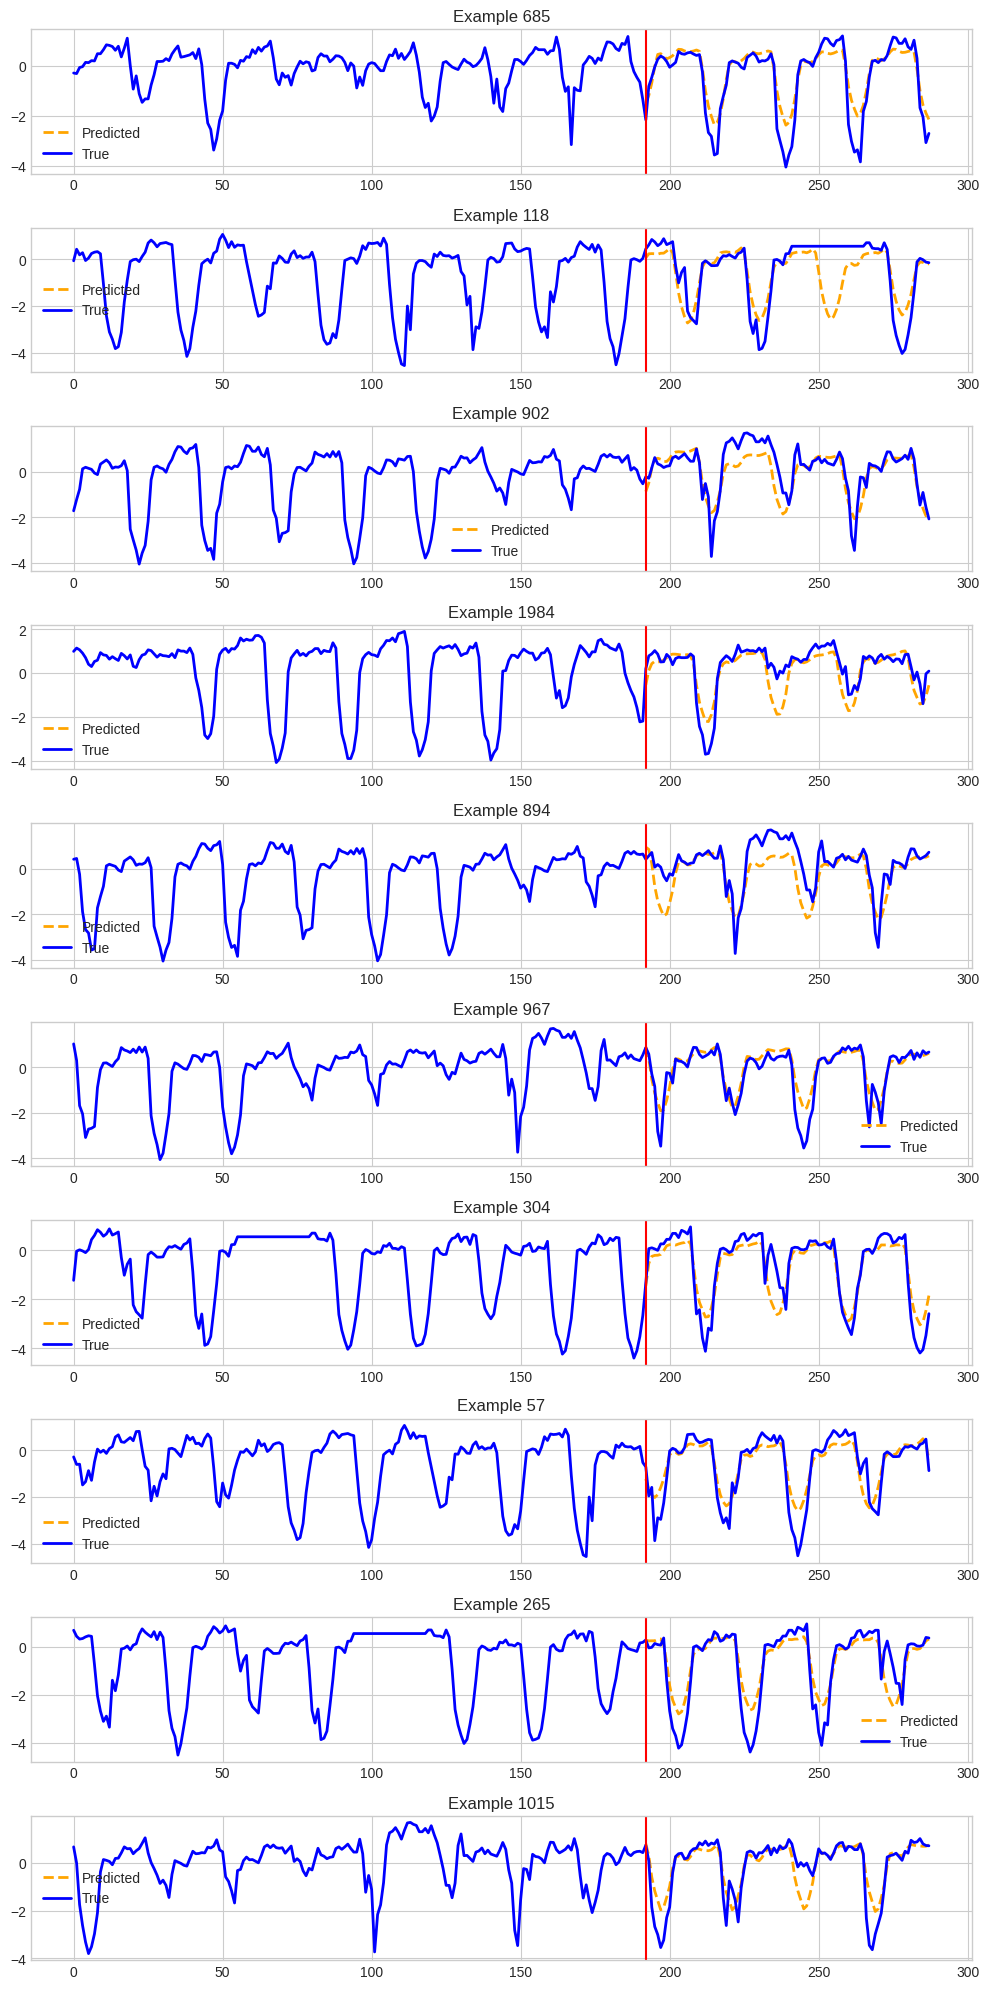

In [44]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [51]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

INFO:p-8808:t-139689755144320:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-8808:t-139689755144320:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-8808:t-139689755144320:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.804800,0.663545
2,0.771000,0.662843
3,0.760800,0.662179
4,0.760900,0.661773
5,0.700900,0.662226
6,0.678400,0.663877
7,0.665100,0.667286
8,0.631900,0.674564
9,0.607300,0.692917
10,0.593600,0.702440


[TrackingCallback] Mean Epoch Time = 0.5702864101954869 seconds, Total Train Time = 22.445860624313354
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.3617064654827118, 'eval_runtime': 1.1044, 'eval_samples_per_second': 2521.825, 'eval_steps_per_second': 39.842, 'epoch': 14.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


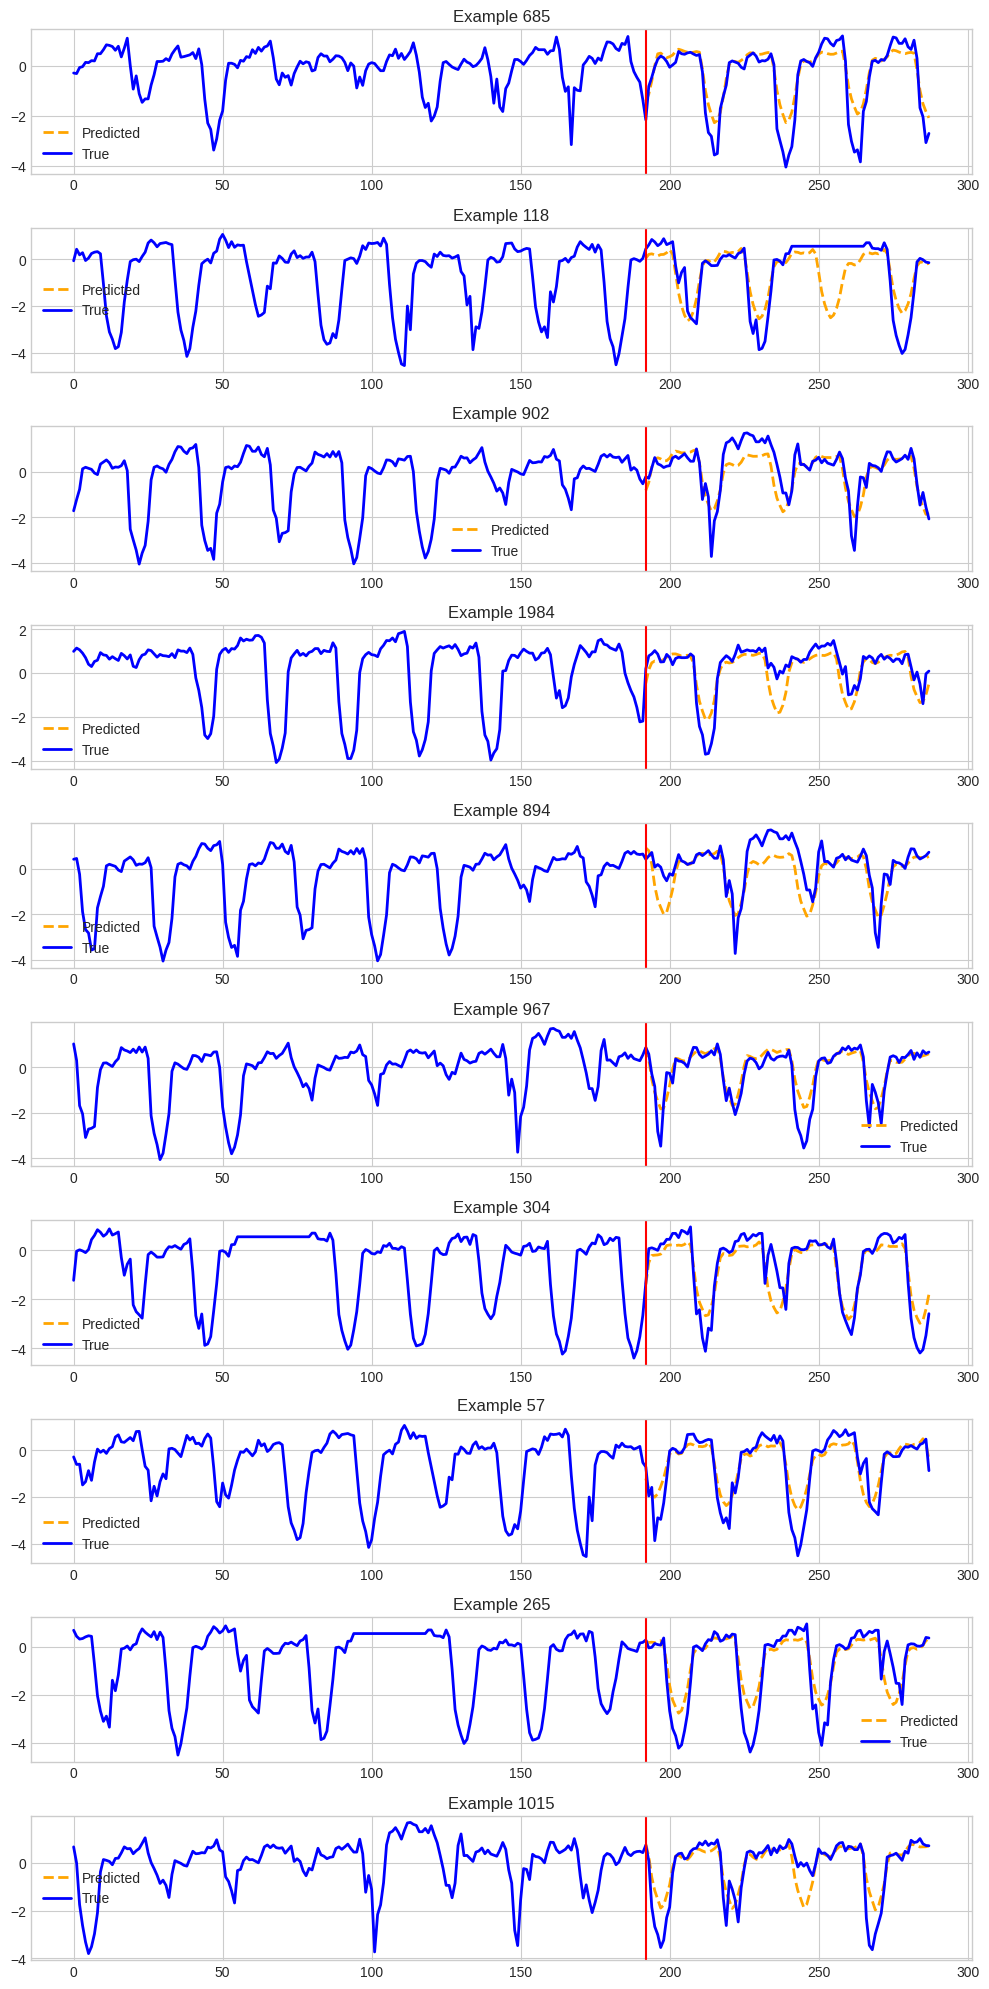

In [52]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

In [50]:
import transformers
print(transformers.__version__)
print(transformers.TrainingArguments.__init__.__code__.co_varnames)

4.38.0
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'evaluation_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_backend', 'bf16_full_eval', 'fp16_full_eval', 'tf32', 'local_rank'

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:p-8808:t-139689755144320:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-8808:t-139689755144320:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-8808:t-139689755144320:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.327600,0.272974
2,0.321100,0.272907
3,0.317600,0.272870
4,0.315600,0.272879
5,0.307900,0.273168
6,0.303400,0.273953
7,0.298300,0.275675
8,0.292500,0.278556
9,0.288500,0.284018
10,0.286300,0.289878


Checkpoint destination directory ttm_finetuned_models/etth1/output/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[TrackingCallback] Mean Epoch Time = 0.6151721844306359 seconds, Total Train Time = 21.875057458877563
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.3617671728134155, 'eval_runtime': 1.1224, 'eval_samples_per_second': 2481.186, 'eval_steps_per_second': 39.2, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


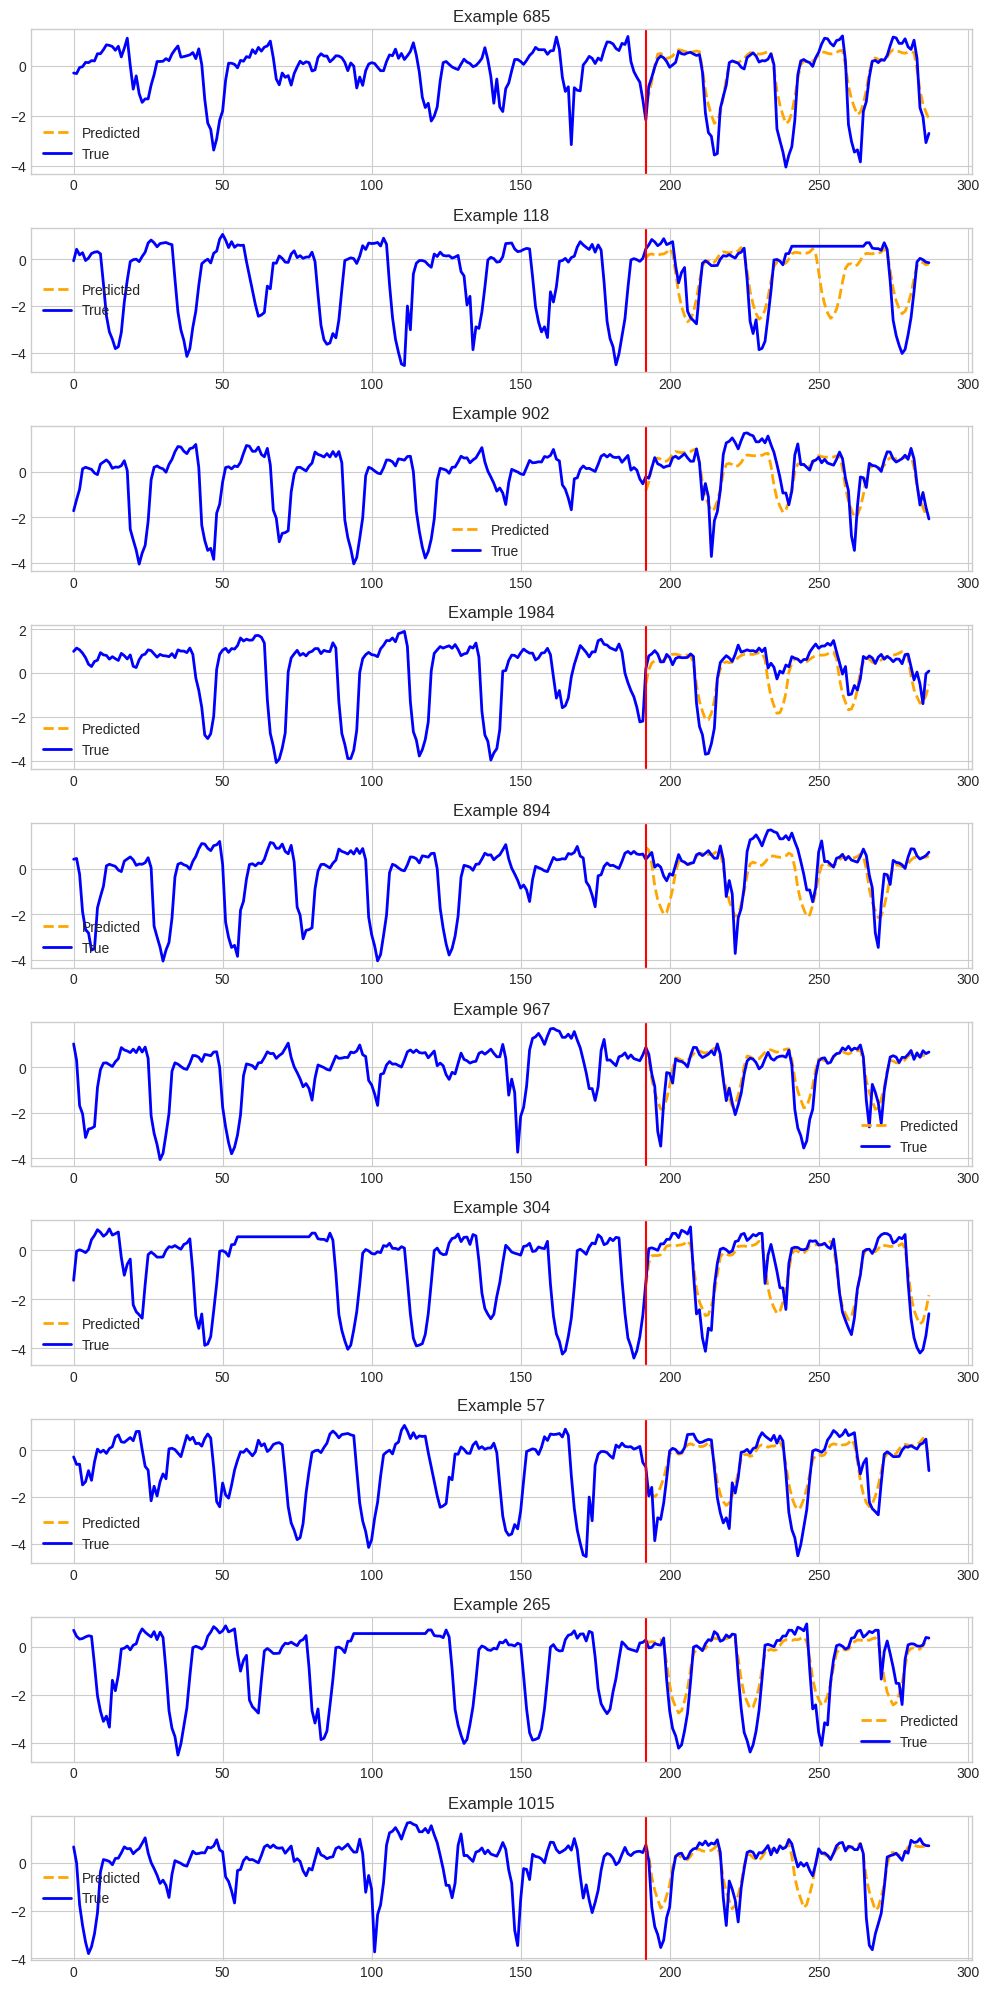

In [53]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:p-8808:t-139689755144320:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-8808:t-139689755144320:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:p-8808:t-139689755144320:get_model.py:get_model:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.33274462819099426, 'eval_runtime': 1.5768, 'eval_samples_per_second': 1796.716, 'eval_steps_per_second': 28.539}
(2833, 48, 7)
(2833, 7, 8, 384)


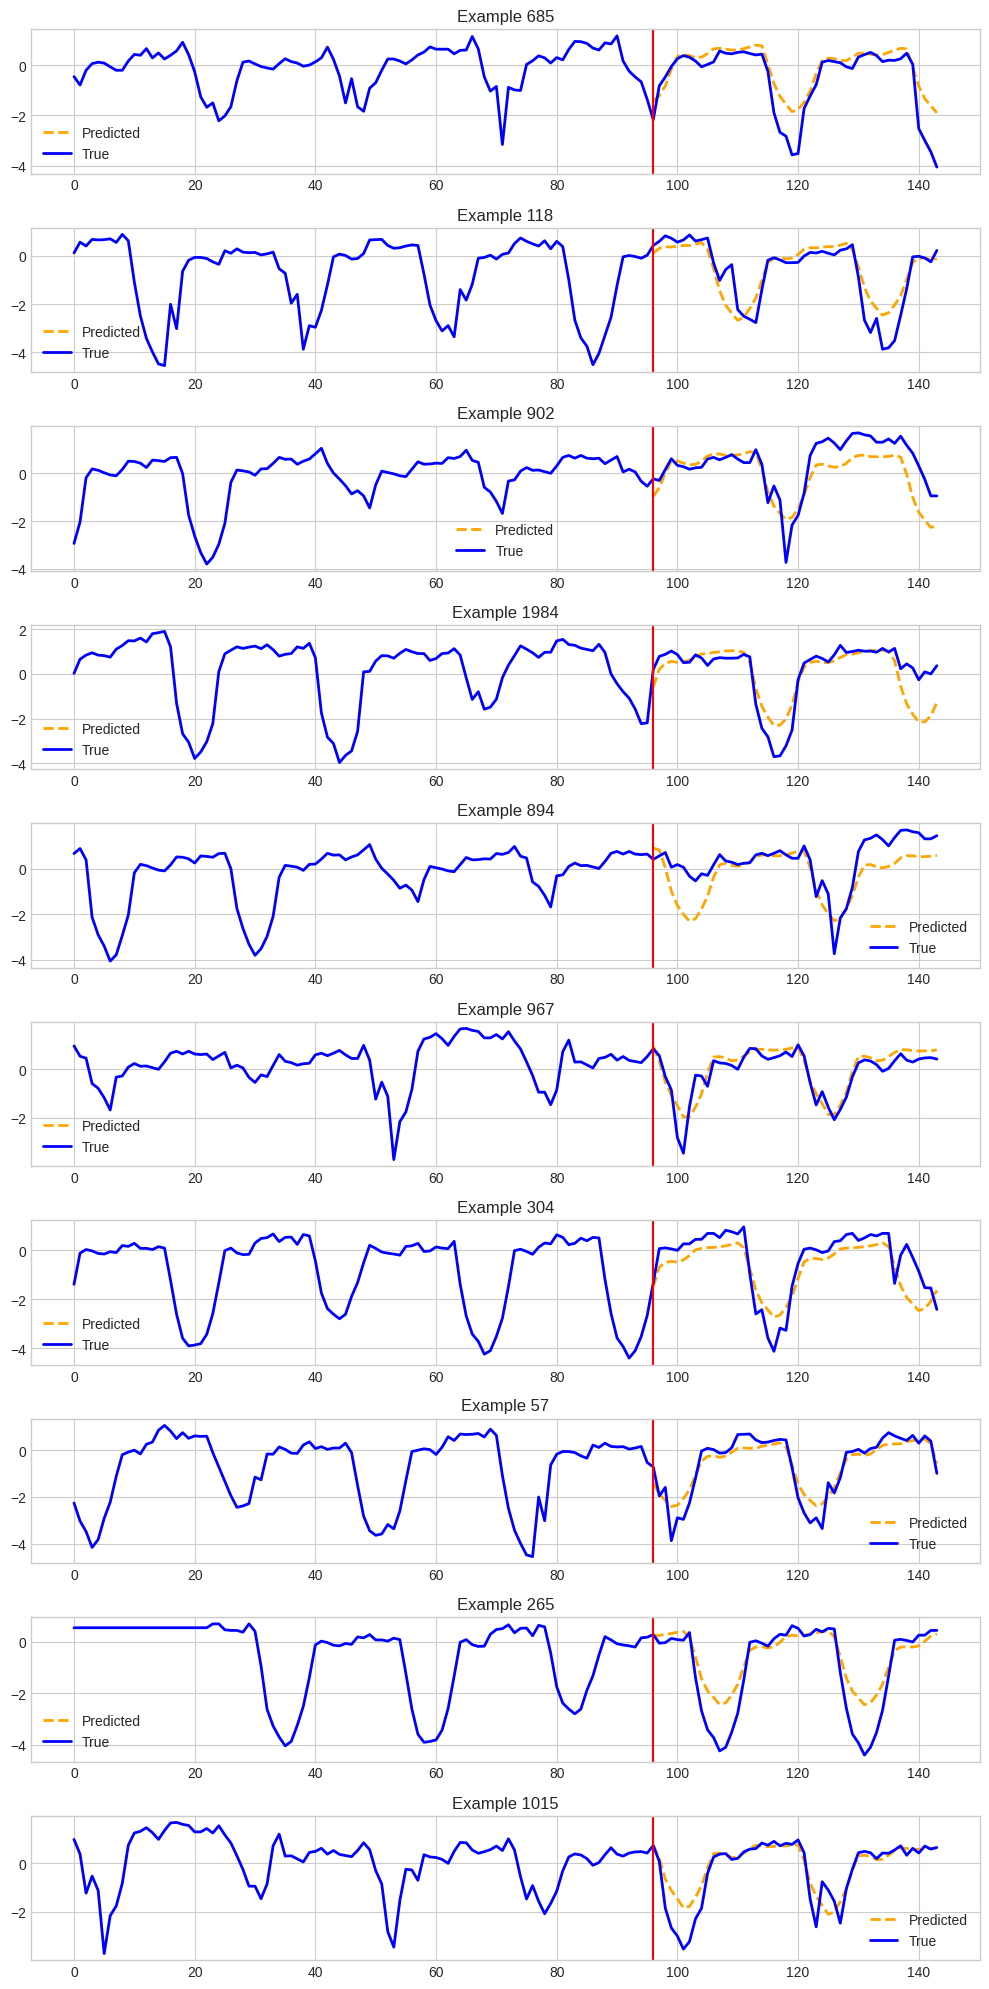

In [54]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-8808:t-139689755144320:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-8808:t-139689755144320:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-8808:t-139689755144320:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96
INFO:p-8808:t-139689755144320:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-8808:t-139689755144320:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.


Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560


INFO:p-8808:t-139689755144320:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.000298364724028334


OPTIMAL SUGGESTED LEARNING RATE = 0.000298364724028334
Using learning rate = 0.000298364724028334


Epoch,Training Loss,Validation Loss
1,0.583000,0.504305
2,0.557200,0.504995
3,0.533300,0.506109
4,0.485600,0.507644
5,0.421300,0.509318
6,0.364900,0.510946
7,0.318600,0.515390
8,0.283500,0.529612
9,0.262100,0.544922
10,0.232600,0.567927


Checkpoint destination directory ttm_finetuned_models/etth1/output/checkpoint-15 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[TrackingCallback] Mean Epoch Time = 0.6858645135706122 seconds, Total Train Time = 26.833393573760986
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.3299565613269806, 'eval_runtime': 1.6805, 'eval_samples_per_second': 1685.821, 'eval_steps_per_second': 26.778, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2833, 48, 7)
(2833, 7, 12, 384)


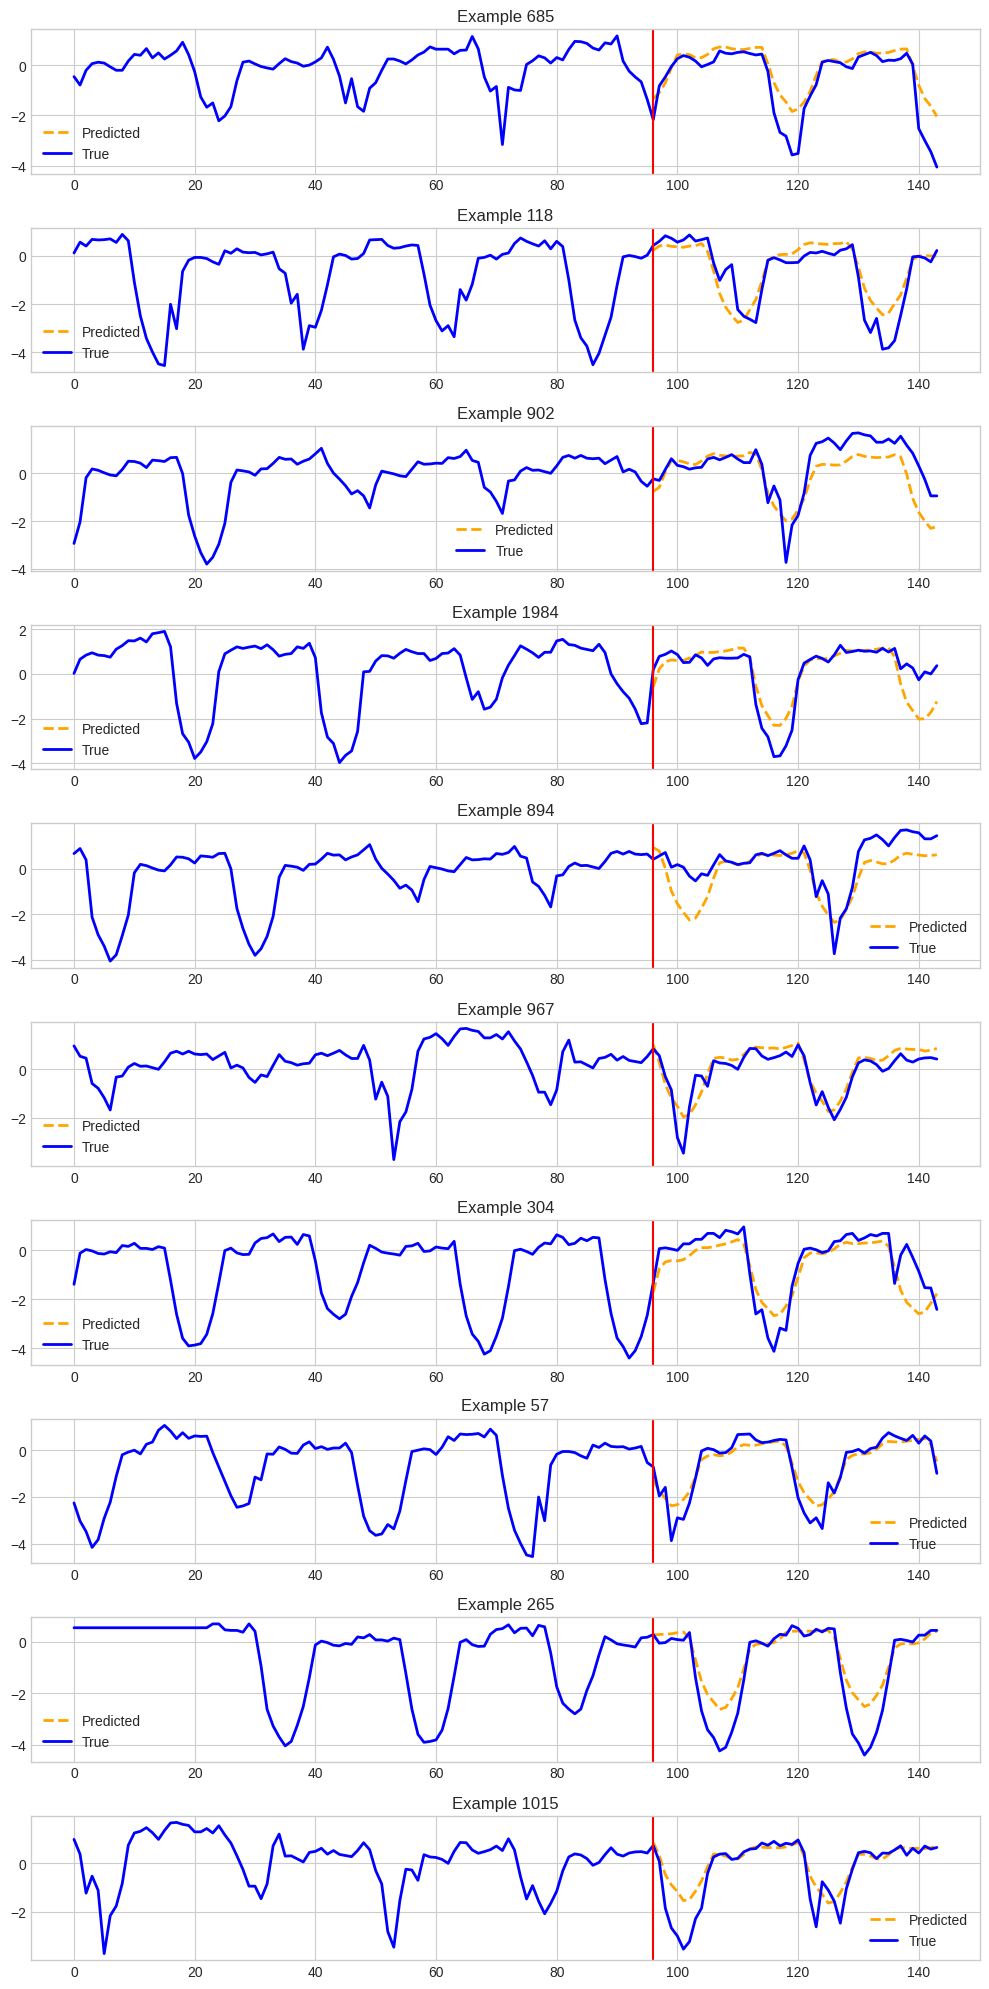

In [55]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)